# Naive Bayes for Sentiment Analysis

In [ ]:
! pip install regex

In [14]:
import re

In [1]:
#! pip install utils
#! pip install bcolz

In [2]:
%matplotlib inline
import utils
import importlib
importlib.reload(utils)
from utils import *
import re, string, collections, bcolz, pickle, os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### The objective of this notebook is to train a sentiment analysis classifier given the games reviews in the dataset. The model must classify text reviews in positive or negative

### Data set

In [3]:
df = pd.read_csv('reviews.csv', lineterminator='\n')

In [4]:
df.head(10)

,score,text,critic,date,title,platform
0,74.0,"it makes a terrible first impression, but ult...",Gaming Nexus,2014-11-18,#KILLALLZOMBIES,PlayStation 4
1,65.0,brings some fresh and inventive ideas to the ...,Playstation Universe,2014-11-17,#KILLALLZOMBIES,PlayStation 4
2,60.0,a fun main mode of play that can get quite add...,Gamers' Temple,2015-02-16,#KILLALLZOMBIES,PlayStation 4
3,60.0,"simply put, feels like half of a game.",DarkStation,2014-12-04,#KILLALLZOMBIES,PlayStation 4
4,60.0,"combined with the price and lack of cross-buy,...",Worth Playing,2014-11-30,#KILLALLZOMBIES,PlayStation 4
5,60.0,"feels like an unfinished product, and it’s a ...",Push Square,2014-11-13,#KILLALLZOMBIES,PlayStation 4
6,90.0,had a lot of love poured into its development...,DualShockers,2017-11-03,.hack//G.U. Last Recode,PlayStation 4
7,85.0,this game has sparked an interest in anime tha...,Digital Chumps,2017-11-14,.hack//G.U. Last Recode,PlayStation 4
8,80.0,"last recode is a very well done compilation, w...",SpazioGames,2017-11-11,.hack//G.U. Last Recode,PlayStation 4
9,80.0,is an incredible package of remastered games....,RPG Site,2017-11-06,.hack//G.U. Last Recode,PlayStation 4


In [5]:
df.shape

(127699, 6)

#### Let's keep just text and score columns

In [6]:
df = df[['text', 'score',]]

In [8]:
df.head(20)

,text,score
0,"it makes a terrible first impression, but ult...",74.0
1,brings some fresh and inventive ideas to the ...,65.0
2,a fun main mode of play that can get quite add...,60.0
3,"simply put, feels like half of a game.",60.0
4,"combined with the price and lack of cross-buy,...",60.0
5,"feels like an unfinished product, and it’s a ...",60.0
6,had a lot of love poured into its development...,90.0
7,this game has sparked an interest in anime tha...,85.0
8,"last recode is a very well done compilation, w...",80.0
9,is an incredible package of remastered games....,80.0


In [9]:
print(f'reviews with score greater than 85: {len(df.loc[df["score"] > 85])}')
print(f'reviews with score less than 50: {len(df.loc[df["score"] < 50])}')

reviews with score greater than 85: 43518
reviews with score less than 50: 20428


In [10]:
pos = df.loc[df['score'] > 85, 'text'].copy().reset_index(drop=True)
neg = df.loc[df['score'] < 50, 'text'].copy().reset_index(drop=True)

In [11]:
len(pos), len(neg)

(43518, 20428)

Let's print some positive reviews examples

In [13]:
for i in range(20):
    print(''.join(pos[np.random.randint(0, len(pos))]))
    print('\n')

 i'm wasting too much time writing this review and need to get back on botw. hope you guys enjoy the game as much as i am!


after playing resident evil 7, i felt sad that it was over which is a sensation i don't feel a lot of the time with games. resident evil 7 brings the series back to its roots in all of the right ways. the game play is tight and has a good amount of difficulty. the story and characters are engaging, except for the main characters. it can be crazy scary as well, which the series was desperately in need of.


simply put,  is an awesome game for any fan of batman, any fan of action games, and i would even say any fan that enjoys just good games.


 as a fan of star trek, i'm overjoyed at this series. thank god for bioware (and gene roddenberry)


uncharted 4 is like uncharted 2, but improved in every single aspect. it improves in shooting, puzzles, climbing, storytelling, multiplayer, and also adds more game mechanics. ignore the xbox and pc fanboys this game deserve

In [12]:
for i in range(4):
    print(''.join(neg[np.random.randint(0, len(neg))]))
    print('\n')

this is destiny in different clothes. good graphics, no content unless you pay more. angryjoe is right. screw ea dont buy anymore of their crap. they deserve 0s even though this game is about a 4.


rpg for casual gamers only.  no degradation on items, just a really long hoarding game with skyrim like fighting.  this is not an rpg and therefore this is not fallout. what's worse is reviewers are too afraid of ticking off bethesda to give them the scores they really deserve. bethesda need to be made aware of the shortcomings so that the next iteration is the fallout game we, they, and this series deserve.


while we're at it.. they don't listen to their customers. the game gets worser by the year!


that's not how you make games, ci games. that's not how you make the marketing. stop being a fake company. i will be completely honest - this negative rating is a counter-attack to the fake reviews made by the developer. the game is probably 4/10, maybe 5/10 but what the studio behind the gam

#### We must add the labels: 0 for negative reviews, 1 for positive reviews

In [13]:
neg = pd.concat([pd.DataFrame(neg), pd.DataFrame(np.zeros(neg.shape), columns=['class'])], 1)
pos = pd.concat([pd.DataFrame(pos), pd.DataFrame(np.ones(pos.shape), columns=['class'])], 1)

In [14]:
neg.head(2)

,text,class
0,a great concept that has been executed dreadfu...,0.0
1,"the chaos implied by ’s wild, imaginative titl...",0.0


In [15]:
pos.head(2)

,text,class
0,had a lot of love poured into its development...,1.0
1,is great fun; each level is superbly crafted ...,1.0


#### Mean, standard deviation and max length of negative reviews

In [16]:
lens = neg['text'].str.len()
lens.mean(), lens.std(), lens.max()

(681.7165654983356, 823.7599066187877, 14736)

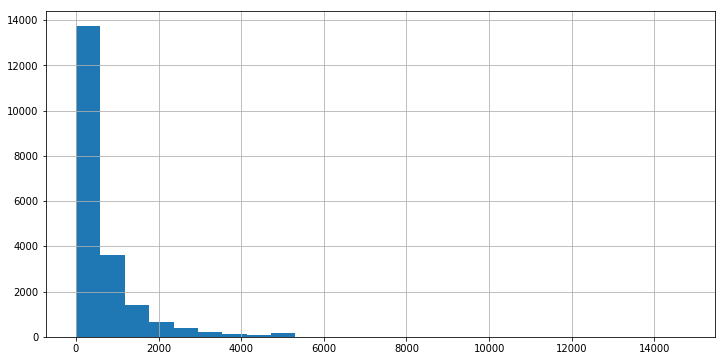

In [17]:
lens.hist(figsize=(12, 6), bins=25);

In [18]:
long_reviews = pos.loc[pos['text'].str.len() > 5000].index
pos.drop(long_reviews, inplace=True)

#### Is desirable to have a balanced dataset (similar quantity of positive and negative instances). So we will pick a random subset of the positive instances

In [19]:
np.random.seed(42)
rand = np.random.permutation(pos.shape[0])
pos = pos.iloc[rand[:neg.shape[0]]].reset_index(drop=True)

In [20]:
neg.shape, pos.shape

((20428, 2), (20428, 2))

#### We concatenate positive and negative reviews

In [21]:
df = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)
df.head()

,text,class
0,i played this game with extremely high expecta...,1.0
1,great in-game graphics that run at 60fps. only...,1.0
2,a masterfully crafted hunting experience that ...,1.0
3,if you're looking for a game that will make yo...,1.0
4,so didn't really pay much attention to this ga...,0.0


In [22]:
df.shape

(40856, 2)

##### Split data into train and test set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['class'].values, test_size=0.2, random_state=42)

In [24]:
len(X_train), len(X_test), len(y_train), len(y_test)

(32684, 8172, 32684, 8172)

#### Defining tokenizer

In [25]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [26]:
re_tok

re.compile(r'([!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~“”¨«»®´·º½¾¿¡§£₤‘’])',
re.UNICODE)

#### Creating bag of words

In [27]:
vect = CountVectorizer(tokenizer=tokenize)

In [28]:
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x7f4831300488>, vocabulary=None)

In [29]:
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [30]:
tf_train

<32684x45346 sparse matrix of type '<class 'numpy.int64'>'
	with 2565486 stored elements in Compressed Sparse Row format>

In [31]:
tf_train[0]

<1x45346 sparse matrix of type '<class 'numpy.int64'>'
	with 23 stored elements in Compressed Sparse Row format>

In [32]:
vocab = vect.get_feature_names()
len(vocab)

45346

In [33]:
vocab[4000: 4005]

['aw2', 'awad', 'await', 'awaited', 'awaiting']

In [34]:
X_train[0]

'the division is a visual feast. from the dynamic lighting to the realistic environments, taking it all in can be breathtaking at times.'

In [35]:
w0 = set([o for o in X_train[0].split(' ')])

In [36]:
w0

{'a',
 'all',
 'at',
 'be',
 'breathtaking',
 'can',
 'division',
 'dynamic',
 'environments,',
 'feast.',
 'from',
 'in',
 'is',
 'it',
 'lighting',
 'realistic',
 'taking',
 'the',
 'times.',
 'to',
 'visual'}

In [37]:
vect.vocabulary_['unless']

42286

In [38]:
tf_train[0, 41989]

0

## Multinomial Naive Bayes

Here we reduce our training data to 2 dimentions (using TruncatedSVD rather than PCA because we are working with sparse matrices) and then we plot it in order to roughly see how classes are separated

In [39]:
svd = TruncatedSVD()
reduced_tf_train = svd.fit_transform(tf_train)

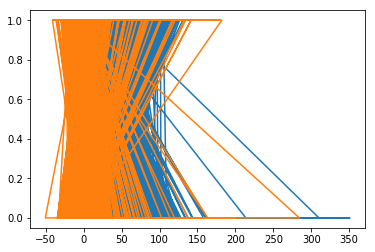

In [40]:
plt.plot(reduced_tf_train, y_train)

In [41]:
p = tf_train[y_train==1].sum(0) + 1
q = tf_train[y_train==0].sum(0) + 1
r = np.log((p/p.sum())/(q/q.sum()))
b = np.log(len(p)/len(q))

In [42]:
pre_preds = tf_test @ r.T + b
preds = pre_preds.T > 0
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.9036955457660304


In [43]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

/home/ml/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.9309838472834068


/home/ml/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [56]:
#plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['Negative', 'Positive'], title='Confusion matrix')

In [51]:
cm=confusion_matrix(y_test, preds.T)

In [53]:
print(cm)

[[3814  286]
 [ 278 3794]]


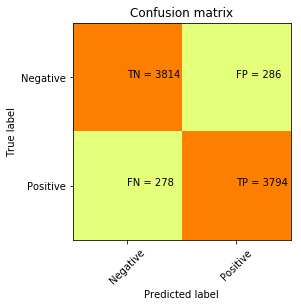

In [55]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()